In [10]:
from astropy.io import ascii
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.gridspec import GridSpec
from astropy.table import vstack
from glob import glob
from astropy.table import Table
import pickle
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
from matplotlib import colors
import matplotlib.patches as mpatches


def init():
    matplotlib.rcParams['xtick.minor.size'] = 6
    matplotlib.rcParams['xtick.major.size'] = 6
    matplotlib.rcParams['ytick.major.size'] = 6
    matplotlib.rcParams['ytick.minor.size'] = 6
    matplotlib.rcParams['lines.linewidth'] = 1.5
    matplotlib.rcParams['axes.linewidth'] = 1.5
    matplotlib.rcParams['font.size']= 16
    matplotlib.rcParams['font.family']= 'sans-serif'
    matplotlib.rcParams['xtick.major.width']= 2.
    matplotlib.rcParams['ytick.major.width']= 2.
    matplotlib.rcParams['ytick.direction']='in'
    matplotlib.rcParams['xtick.direction']='in'

init()

In [2]:
filt = 'r'
with open('output/bns_Bulla_parameter_grid_Andreoni_theta_simulations_%sband.dat'%(filt),'rb') as f:
    r = pickle.load(f)
    
filt = 'J'    
with open('output/bns_Bulla_parameter_grid_Andreoni_theta_simulations_%sband.dat'%(filt),'rb') as f:
    J = pickle.load(f)

Install gpytorch if you want to use it...


In [6]:
r = r.group_by('theta')
J = J.group_by('theta')

Text(0, 0.5, 'Area90')

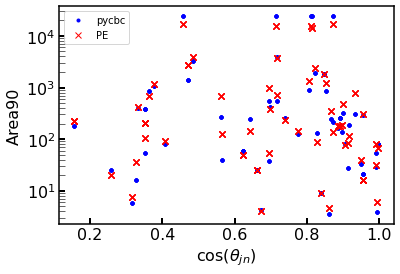

In [11]:
ls = glob('/Users/viraj/winter/gwemopt_sims/output_parallel/*.csv')
A90 = []
pethetas = []
peA90 = []
thetas = []
distances = []
pe_distances = []

for l in ls:
    rate = l.split('/')[-1].split('_')[0]
    isGal = int(l.split('/')[-1].split('_')[2].split('isGal')[-1])
    if isGal==1:
        #with open('/Users/viraj/gwemlightcurves/output/bns_samples_%s_catalog_Jband.pickle'%(rate),'rb') as f:
        #    dat = pickle.load(f)
        continue
        #dat = Table.read('/Users/viraj/gwemlightcurves/output/bns_samples_%s_catalog_ejecta_masses.dat'%(rate),format='ascii')
        
    else:
        with open('/Users/viraj/gwemlightcurves/output/bns_samples_%s_Jband.pickle'%(rate),'rb') as f:
            dat = pickle.load(f)
        #dat = Table.read('/Users/viraj/gwemlightcurves/output/bns_samples_%s_ejecta_masses.dat'%(rate),format='ascii')
            
    lccrds = SkyCoord(ra=dat['ra'],dec=dat['dec'],unit=(u.radian,u.radian))
    
    isPe = int(l.split('/')[-1].split('_')[1].split('isPE')[-1])
    
    t = Table.read(l)
    crds = SkyCoord(ra=t['ra'],dec=t['dec'],unit=(u.deg,u.deg))
    idx,d2d,d3d = crds.match_to_catalog_sky(lccrds)
    dat = dat[idx]
    #print(d2d)
    if isPe==1:
        
        for ind in range(len(t)):
            pethetas.append(dat[ind]['theta_jn'])
            peA90.append(t[ind]['area90'])
            if t[ind]['area90'] ==0:
                print(t[ind]['distance'])
            pe_distances.append(t[ind]['distance'])
        
    else:
        for ind in range(len(t)):
            thetas.append(dat[ind]['theta_jn'])
            A90.append(t[ind]['area90'])
            distances.append(t[ind]['distance'])        
A90 = np.array(A90)
peA90 = np.array(peA90)
thetas = np.array(thetas)
pethetas = np.array(pethetas)

plt.plot(np.abs(np.cos(thetas)),A90,'.',c='blue',label='pycbc')
plt.plot(np.abs(np.cos(thetas)),A90,'.',c='blue')

plt.plot(np.abs(np.cos(pethetas)),peA90,'x',c='red',label='PE')
plt.plot(np.abs(np.cos(pethetas)),peA90,'x',c='red')



plt.yscale('log')
plt.legend(fontsize=10)
plt.xlabel(r'cos($\theta_{jn}$)')
plt.ylabel(r'Area90')
#plt.savefig(r'theta_A90_1.pdf',bbox_inches='tight')

In [30]:
thetas = np.arccos(np.abs(np.cos(np.array(thetas))))
distances = np.array(distances)
sortinds = np.argsort(thetas)
distances = distances[sortinds]
thetas = thetas[sortinds]
uniq_thetas, uniqinds = np.unique(thetas,return_index=True)
uniq_distances = distances[uniqinds]

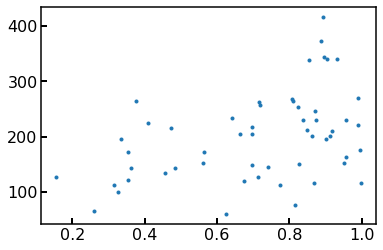

In [31]:
plt.plot(np.abs(np.cos(uniq_thetas)),uniq_distances,'.')

In [87]:
def is_detection(tts,mags,limmag,search_time_days):
    bright_inds = mags<limmag
    if len(tts[bright_inds]) ==0:
        return 0
    
    t_brights = tts[bright_inds]
    
    t_bright_max = np.max(t_brights)
    
    #print(t_bright_max)
    if t_bright_max >= search_time_days:
        return 1
    else:
        return 0

In [200]:
def calc_fdets(limmags,search_time_days):
    fdets = {}
    fdets['J'], fdets['r'] = {}, {}
    fdets['J']['30'], fdets['J']['60'] = [], []
    fdets['r']['30'], fdets['r']['60'] = [], []

    ls = glob('/Users/viraj/winter/gwemopt_sims/output_parallel/*.csv')
    for ind in range(len(J.groups)):
        Jg = J.groups[ind]
        rg = r.groups[ind]
    
        Jg = Jg.group_by('phi')
        rg = rg.group_by('phi')
    
    
        dist = uniq_distances[ind]
        DM = 5*np.log10(dist*1e5)
    
        for phi_ind in range(len(Jg.groups)):
            Jgphi = Jg.groups[phi_ind]
            rgphi = rg.groups[phi_ind]
            phi = Jgphi['phi'][0]
            nJdets = 0
            nrdets = 0
            for row_ind in range(len(Jgphi)):
                app_mags_J = Jgphi[row_ind]['mag'][0]+DM
                app_mags_r = rgphi[row_ind]['mag'][0]+DM
                ts = Jgphi[row_ind]['t']
                Jdet = is_detection(ts,app_mags_J,limmags,search_time_days)
                rdet = is_detection(ts,app_mags_r,limmags,search_time_days)
            
                if Jdet==1:
                    nJdets+= 1
                if rdet==1:
                    nrdets+= 1
            fdets['J']['%i'%(phi)].append(nJdets/len(Jgphi))
            fdets['r']['%i'%(phi)].append(nrdets/len(rgphi))
    fdets['J']['30'] = np.array(fdets['J']['30'])
    fdets['r']['30'] = np.array(fdets['r']['30'])
    fdets['J']['60'] = np.array(fdets['J']['60'])
    fdets['r']['60'] = np.array(fdets['r']['60'])

        #print(phi,nJdets,nrdets,len(Jgphi))
    return fdets    
        
    
    #print(Jg['mag'][0][0]+DM)
    
    #print('theta : ',Jg[0]['theta'],rg[0]['theta'],uniq_thetas[ind]*180/np.pi,uniq_distances[ind],DM)

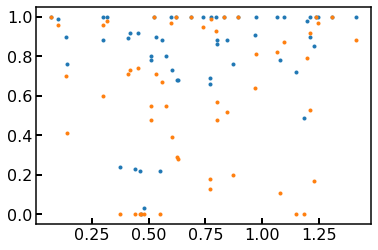

In [186]:
#plt.plot(uniq_thetas,fdets['J']['30'],'.')
plt.plot(uniq_thetas,fdets['J']['60'],'.')
#plt.plot(uniq_thetas,fdets['r']['30'],'.')
plt.plot(uniq_thetas,fdets['r']['60'],'.')

In [195]:
def binned_fdets(fdets):
    plot_bins = np.array([0,0.25,0.5,0.75,1])
    bins = np.array([0,0.2,0.4,0.6,0.8,1])
    b_inds = np.digitize(np.abs(np.cos(uniq_thetas)),bins)

    bin_dists = []
    b_fdets = {}
    b_fdets['J'], b_fdets['r'] = {}, {}
    b_fdets['J']['30'], b_fdets['J']['60'] = [], []
    b_fdets['r']['30'], b_fdets['r']['60'] = [], []
    b_distances = []

    for filt in ['r','J']:
        for phi in ['30','60']:
            b_distances = []
            b_n_ligos = []
            for i in range(1,6):
                b_distances.append(np.mean(uniq_distances[np.where(b_inds==i)[0]]))
                b_n_ligos.append(len(uniq_distances[np.where(b_inds==i)[0]]))
                b_fdets[filt][phi].append(np.median(fdets[filt][phi][np.where(b_inds==i)[0]]))
                #ntot.append(len(distances[np.where(inds==i)[0]]))

    b_distances = np.array(b_distances)
    b_n_ligos = np.array(b_n_ligos)/np.sum(b_n_ligos)
    return b_n_ligos, b_fdets, b_distances

In [193]:
b_distances,b_n_ligos

(array([126.61577208, 146.78064362, 173.85512283, 174.31577689,
        234.52392801]),
 array([0.01851852, 0.14814815, 0.11111111, 0.22222222, 0.5       ]))

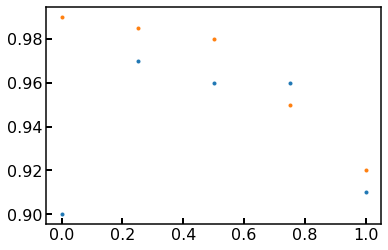

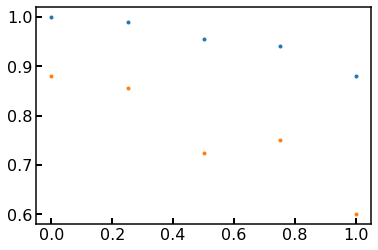

In [194]:
plt.figure()
plt.plot(plot_bins,b_fdets['J']['30'],'.')
plt.plot(plot_bins,b_fdets['r']['30'],'.')

plt.figure()
plt.plot(plot_bins,b_fdets['J']['60'],'.')
plt.plot(plot_bins,b_fdets['r']['60'],'.')

[0.01518519 0.13185185 0.09888889 0.19555556 0.415     ]
[0.01759259 0.13925926 0.09833333 0.19222222 0.41      ]
[0.01666667 0.1437037  0.10666667 0.21333333 0.455     ]
[0.01851852 0.14666667 0.10611111 0.20888889 0.44      ]


Text(0.5, 0, 'cos($\\theta$)')

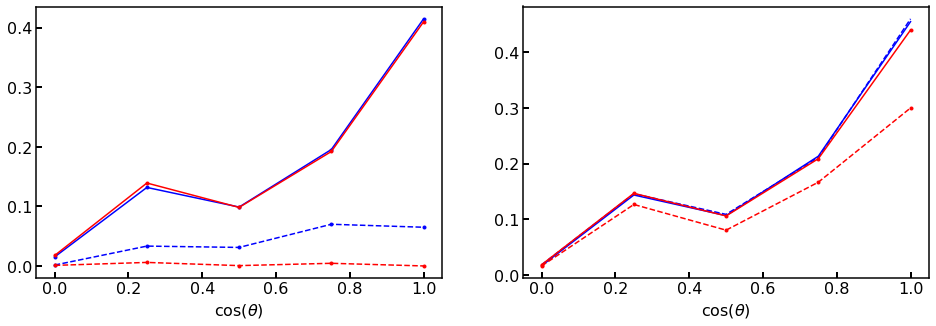

In [242]:
fig = plt.figure(figsize=(16,5))
gs = GridSpec(1,2)
ax1 = fig.add_subplot(gs[0])
fdets = calc_fdets(22,4)
b_n_ligos, b_fdets, b_distances = binned_fdets(fdets)
print(b_n_ligos*b_fdets['J']['30'])
ax1.plot(plot_bins,b_n_ligos*b_fdets['J']['30'],'.',linestyle='-',c='blue')
ax1.plot(plot_bins,b_n_ligos*b_fdets['r']['30'],'.',linestyle='--',c='blue')

fdets = calc_fdets(22,4)
b_n_ligos, b_fdets, b_distances = binned_fdets(fdets)
print(b_n_ligos*b_fdets['J']['60'])
ax1.plot(plot_bins,b_n_ligos*b_fdets['J']['60'],'.',linestyle='-',c='red')
ax1.plot(plot_bins,b_n_ligos*b_fdets['r']['60'],'.',linestyle='--',c='red')
ax1.set_xlabel(r'cos($\theta$)')

ax2 = fig.add_subplot(gs[1])
#plt.figure()
fdets = calc_fdets(21,1)
b_n_ligos, b_fdets, b_distances = binned_fdets(fdets)
print(b_n_ligos*b_fdets['J']['30'])
ax2.plot(plot_bins,b_n_ligos*b_fdets['J']['30'],linestyle='-',c='blue')
ax2.plot(plot_bins,b_n_ligos*b_fdets['r']['30'],linestyle='--',c='blue')


fdets = calc_fdets(21,1)
b_n_ligos, b_fdets, b_distances = binned_fdets(fdets)
print(b_n_ligos*b_fdets['J']['60'])
ax2.plot(plot_bins,b_n_ligos*b_fdets['J']['60'],'.',linestyle='-',c='red')
ax2.plot(plot_bins,b_n_ligos*b_fdets['r']['60'],'.',linestyle='--',c='red')
ax2.set_xlabel(r'cos($\theta$)')

In [44]:
fdets = []

ls = glob('/Users/viraj/winter/gwemopt_sims/output_parallel/*.csv')
for ind in range(len(J.groups)):
for l in ls:
    rate = l.split('/')[-1].split('_')[0]
    isGal = int(l.split('/')[-1].split('_')[2].split('isGal')[-1])
    if isGal==1:
        #with open('/Users/viraj/gwemlightcurves/output/bns_samples_%s_catalog_Jband.pickle'%(rate),'rb') as f:
        #    dat = pickle.load(f)
        continue
        #dat = Table.read('/Users/viraj/gwemlightcurves/output/bns_samples_%s_catalog_ejecta_masses.dat'%(rate),format='ascii')

    isPe = int(l.split('/')[-1].split('_')[1].split('isPE')[-1])
    t = Table.read(l)
    
    if isPe == 1:
        continue
    
    sched = Table.read(l)
    for sc in sched:
        print(sc['theta_jn'])
    Jg = J.groups[ind]
    rg = r.groups[ind]
    
    Jg = Jg.group_by('phi')
    rg = rg.group_by('phi')
    
    
    dist = uniq_distances[ind]
    DM = 5*np.log10(dist*1e5)
    
    for phi_ind in range(len(Jg.groups)):
        Jgphi = Jg.groups[phi_ind]
        rgphi = rg.groups[phi_ind]
        
        app_mags_J = Jg['mag'][0][0]+DM
        app_mags_r = rg['mag'][0][0]+DM
    
    #print(Jg['mag'][0][0]+DM)
    
    #print('theta : ',Jg[0]['theta'],rg[0]['theta'],uniq_thetas[ind]*180/np.pi,uniq_distances[ind],DM)

In [58]:
sched

col0,event,distance,ra,dec,is_localized,mag_threshold,airmass,pointings_to_detection,hours_to_detection,area90
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,76.0,123.10428318692932,132.75262,29.178780000000003,1.0,21.22011,1.57147,8.0,6.388977277597103,2021.1108954109345
1,76.0,123.10428318692932,132.75262,29.178780000000003,1.0,22.20276,1.60705,8.0,22.319937277565867,2021.1108954109345
0,23.0,368.613114788,236.39201400000002,-29.333000000000002,0.0,--,--,--,--,45.92509914889853
0,93.0,191.81113657443316,6.130833333330001,14.397222222219998,0.0,--,--,--,--,393.32709845028944
0,24.0,271.842519203,57.53854800000001,-34.754436,0.0,--,--,--,--,149.10904014784796
0,39.0,276.694,196.383224,60.16944900000001,1.0,22.35943,1.34745,31.0,72.33192513964137,231.2581841636925
0,37.0,275.423,222.63300000000004,27.96606,0.0,--,--,--,--,5948.598622139796
0,11.0,41.70283772336437,151.70791666667,12.628888888889996,0.0,--,--,--,--,5.89800495208941
0,44.0,160.39801510647445,247.4043395535,39.3704616362,0.0,--,--,--,--,261.05966555029215


In [78]:
1*(3*9*3600/(450*1))

216.0

In [56]:
2.5*np.log10(6)/2

0.9726890629795546